In [2]:
import os
import torch
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipyfilechooser import FileChooser

In [1]:
from IPython.display import Image

# Analysis of submission 2 

In this tutorial we will use submission 2, as we can do both the all vs all analysis and the all vs GT analysis. Let's do all vs GT first.

## Computing SVD from Ground Truth and projection submissions

First I will load the example config file we provided so we can look at the keys it has

In [3]:
# Select path to SVD config file
# An example of this file is available in the path ../config_files/config_svd.yaml
config_svd_path = FileChooser(os.path.expanduser("~"))
config_svd_path.filter_pattern = "*.yaml"
display(config_svd_path)

FileChooser(path='/mnt/home/gwoollard', filename='', title='', show_hidden=False, select_desc='Select', change…

In [ ]:
with open(config_svd_path.value, "r") as f:
    config_example = yaml.safe_load(f)

In [ ]:
print(f"keys for config: {config_example.keys()}")
print(f"keys for output_options: {config_example['output_options'].keys()}")

Here is a brief explanation of each key

* path_to_volumes (str): this is the path to your submissions (the result of running the preprocessing). They should be called submission_0.pt, submission_1.pt, ...

* box_size_ds (int): you can choose to downsample the volumes to speed up the analysis, or to get rid of high frequency features.

* submission_list (List): here you can choose which submissions are used for the analysis. If you want to use submissions 0, 3, 6; then this should be [0, 3, 6]

* experiment_mode (str): the options are "all_vs_all", "all_vs_ref". If you are using ref, then SVD is computed from the refence volumes and the rest of the volumes are projected to it. Otherwise, all volumes are used to do the projection

* power_spectrum_normalization (dict): here we set up the power spectrum normalization. We do this as the submissions have very different resolutions. There are two parameters that should be included here
    * ref_vol_key (str): this is the ice cream flavour of the submission that should be used as a reference, e.g., "Chocolate Chip"
    * ref_vol_index (int): this says which volume of that submission should be used, e.g., setting it up as `0` would use the first volume of that submission.

* path_to_reference (str): path to the reference volumes (only needed if mode is "all_vs_ref")
* dtype (str): can be float32 or float64
* output_options (dict): dictionary with options to personalize the output
    * output_file (str): path to where the results should be saved. If the path does not exist it will be created. Use filetype ".pt" as this will be created as a pytorch file.
    * save_volumes (bool): whether or not to save the volumes used (this will save the normalized, downsampled, and mean-removed volumes)
    * save_svd_matrices (bool): whether or not to save the matrices computed from the SVD

After setting up your config, simply run in your terminal (make sure to install and activate the environment)

```bash
cryo_challenge run_svd --config /path/to/config
```

After the code is done running you can load your results as

# Visualizing the results

Before visualizing the results, let's define some useful functions for plotting

In [ ]:
def plot_all_vs_all(results, fig_title="", fig_fname=None):
    weights = []
    for i, id in enumerate(results["metadata"].keys()):
        populations = results["metadata"][id]["populations"]
        weights += populations.numpy().tolist()

    weights = torch.tensor(weights)
    weights = weights / weights.sum()

    fig, ax = plt.subplots(3, 4, figsize=(3 * 5, 2 * 5))

    for i, id in enumerate(results["metadata"].keys()):
        sns.kdeplot(
            x=results["coeffs"][:, 0],
            y=results["coeffs"][:, 1],
            cmap="viridis",
            fill=True,
            cbar=False,
            ax=ax.flatten()[i],
            weights=weights,
        )

        idx_0, idx_1 = results["metadata"][id]["indices"]
        populations = results["metadata"][id]["populations"]

        ax.flatten()[i].scatter(
            x=results["coeffs"][idx_0:idx_1, 0],
            y=results["coeffs"][idx_0:idx_1, 1],
            color="red",
            s=populations / populations.max() * 200,
            marker="o",
            linewidth=0.3,
            edgecolor="white",
            label=id,
        )

        ax.flatten()[i].set_xlabel("SVD 1", fontsize=12)
        ax.flatten()[i].set_ylabel("SVD 2", fontsize=12)
        ax.flatten()[i].legend(fontsize=12)

    # adjust horizontal space
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    fig.suptitle(fig_title, fontsize=16, y=0.95)

    if fig_fname is not None:
        plt.savefig(fig_fname, dpi=100, bbox_inches="tight")

    return


def plot_all_vs_ref_plot1(results, fig_title, fig_fname=None):
    fig, ax = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True)

    for i, id in enumerate(results["metadata"].keys()):
        sns.scatterplot(
            x=results["coeffs_ref"][:, 0],
            y=results["coeffs_ref"][:, 1],
            edgecolors=None,
            linewidth=0,
            marker="X",
            label="Ground Truth",
            ax=ax.flatten()[i],
            s=40,
            alpha=0.8,
            color="#a1c9f4",
        )

        idx_0, idx_1 = results["metadata"][id]["indices"]
        populations = results["metadata"][id]["populations"]

        ax.flatten()[i].scatter(
            x=results["coeffs"][idx_0:idx_1, 0],
            y=results["coeffs"][idx_0:idx_1, 1],
            color="red",
            s=populations / populations.max() * 200,
            marker="o",
            linewidth=0.3,
            edgecolor="white",
            label=id,
        )

        ax.flatten()[i].set_xlabel("SVD 1", fontsize=12)
        ax.flatten()[i].set_ylabel("SVD 2", fontsize=12)
        ax.flatten()[i].legend(loc="upper left", fontsize=12)

    # ax[0].set_title("Submission vs all submissions")
    ax[2, 3].axis("off")

    # adjust horizontal space
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    fig.suptitle(fig_title, fontsize=16, y=0.95)

    if fig_fname is not None:
        plt.savefig(fig_fname, dpi=100, bbox_inches="tight")

    return


def plot_all_vs_ref_plot2(results, fig_title, fig_fname=None):
    fig, ax = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True)

    for i, id in enumerate(results["metadata"].keys()):
        frq, edges = np.histogram(results["coeffs_ref"][:, 0], bins=30)
        ax.flatten()[i].bar(
            edges[:-1],
            frq / frq.max(),
            width=np.diff(edges),
            label="Ground Truth",
            alpha=0.8,
            color="#a1c9f4",
        )

        idx_0, idx_1 = results["metadata"][id]["indices"]
        populations = results["metadata"][id]["populations"]

        ax.flatten()[i].scatter(
            x=results["coeffs"][idx_0:idx_1, 0],
            y=populations / populations.max(),
            color="red",
            marker="o",
            s=60,
            linewidth=0.3,
            edgecolor="white",
            label=id,
        )

        ax.flatten()[i].set_xlabel("SVD 1", fontsize=12)
        ax.flatten()[i].set_ylabel("SVD 2", fontsize=12)
        ax.flatten()[i].legend(loc="upper left", fontsize=12)

    # ax[0].set_title("Submission vs all submissions")
    ax[2, 3].axis("off")

    # adjust horizontal space
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    fig.suptitle(fig_title, fontsize=16, y=0.95)

    if fig_fname is not None:
        plt.savefig(fig_fname, dpi=100, bbox_inches="tight")

    return

# Analysis for Set 2

## Submissions vs GT

In [ ]:
# Select path to SVD results
results_svd_all_vs_ref_path = FileChooser(os.path.expanduser("~"))
results_svd_all_vs_ref_path.filter_pattern = "*.pt"
display(results_svd_all_vs_ref_path)

In [ ]:
results_svd_all_vs_ref = torch.load(results_svd_all_vs_ref_path.value)

The results look like

In [ ]:
results_svd_all_vs_ref.keys()

In [ ]:
results_svd_all_vs_ref["metadata"]["Salted Caramel"].keys()

Here is a brief description of each key

* coeffs: these are the coefficients of the expansion for the submissions. They are flattened, so their shape is something like `(n_submissions * 80, D**3)`. Where `D` is the box size after downsampling.

* coeffs_ref: similar to coeffs, but these are the coefficients for the reference volumes (the ones used to compute the svd).

* metadata: this is a dictionary with information about the submissions, the keys are the id of each submission (the ice cream flavor)
    * n_vols: how many volumes were included in this submission (ideally, 80)
    * populations: normalized submitted populations
    * indices: since the coeffs are flattened, this indices tells you the range for the coefficients of this submission `coeffs[indices[0], indices[1]]`

* config: a copy of the config used to generate the data

* sing_vals: singular values computed with SVD

If you chose to save volumes. The volumes saved are downsampled, normalized and without mean. The means are provided in case they are necessary.

* volumes: Submission volumes. They are useful for rerunning things or to create animations.
* mean_volumes: mean volumes for each submission
* ref_volumes: same, but for the reference volumes
* mean_ref_volume: mean reference volume.

If you chose to save the singular value matrices
* U: right-singular vectors
* S: singular values
* V_T: left-singular vectors



### Results

First we will compare the first principal components found

In [ ]:
title_fig = "your title"
fig_fname = "your figfname"  # for saving a file (optional)

plot_all_vs_ref_plot1(results_svd_all_vs_ref, title_fig, fig_fname=fig_fname)

Here is an example of how this figures looks

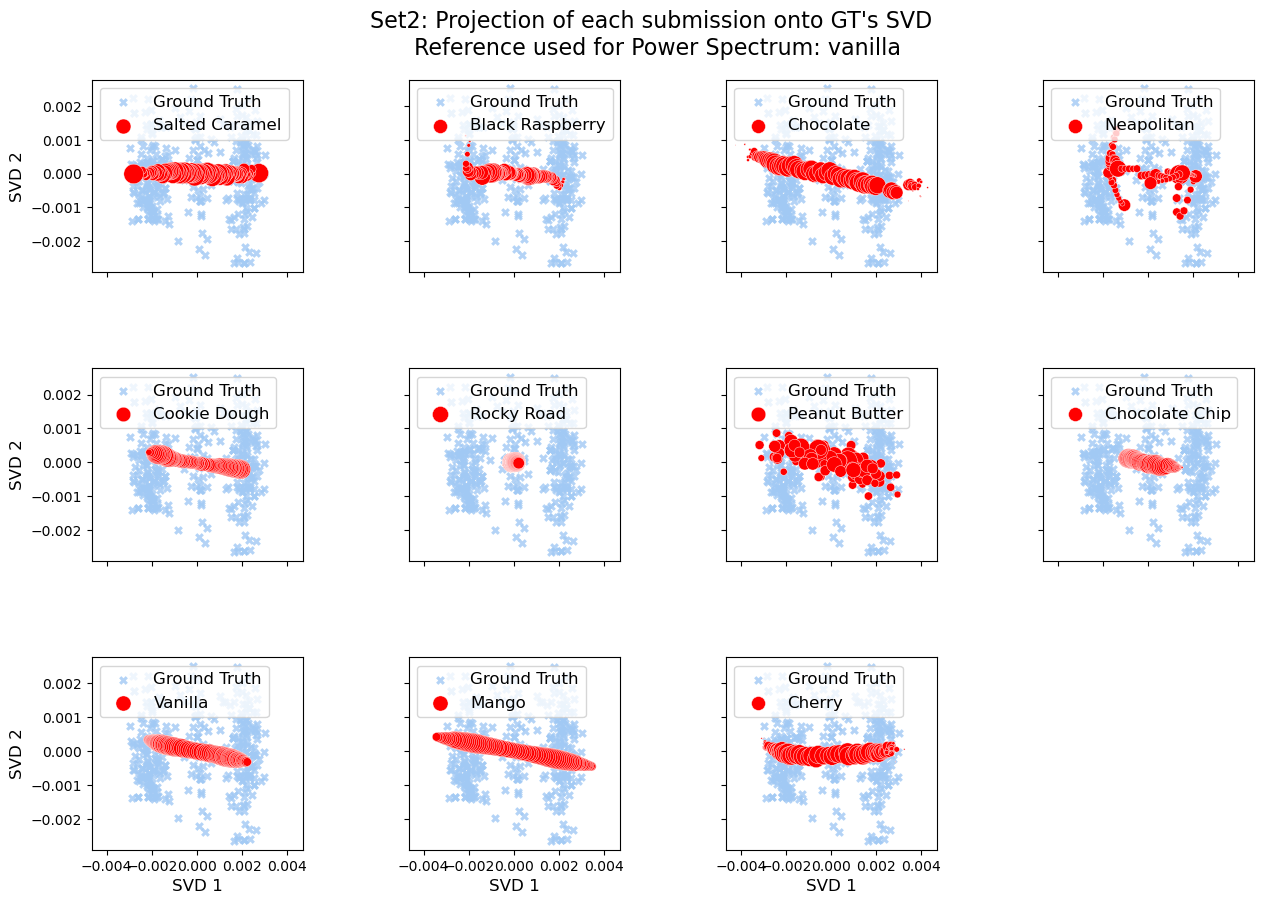

In [6]:
Image(filename="figures/example_all_vs_ref_plot1.png")

In [ ]:
plot_all_vs_ref_plot2(results_svd_all_vs_ref, title_fig, fig_fname=fig_fname)

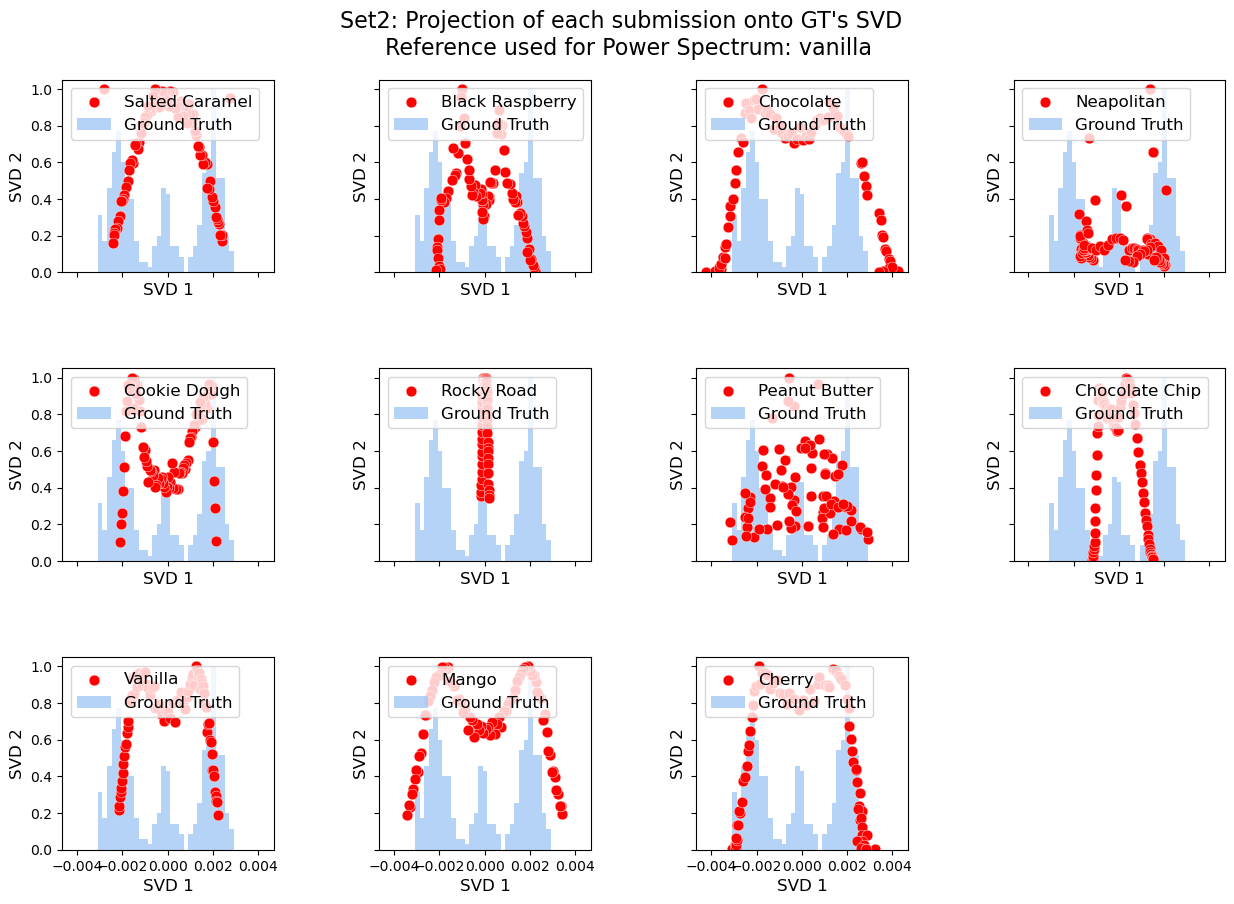

In [7]:
Image(filename="figures/svd_example_all_vs_ref_plot2.png")

## Submissions vs Submissions

As before, let's load the results

In [ ]:
# Select path to SVD results
results_svd_all_vs_all_set2_path = FileChooser(os.path.expanduser("~"))
results_svd_all_vs_all_set2_path.filter_pattern = "*.pt"
display(results_svd_all_vs_all_set2_path)

In [ ]:
results_svd_all_vs_all_set2 = torch.load(results_svd_all_vs_all_set2_path.value)

In [ ]:
title_fig = "your title"
fig_fname = "your figfname"  # for saving a file (optional)

plot_all_vs_ref_plot1(results_svd_all_vs_ref, title_fig, fig_fname=fig_fname)

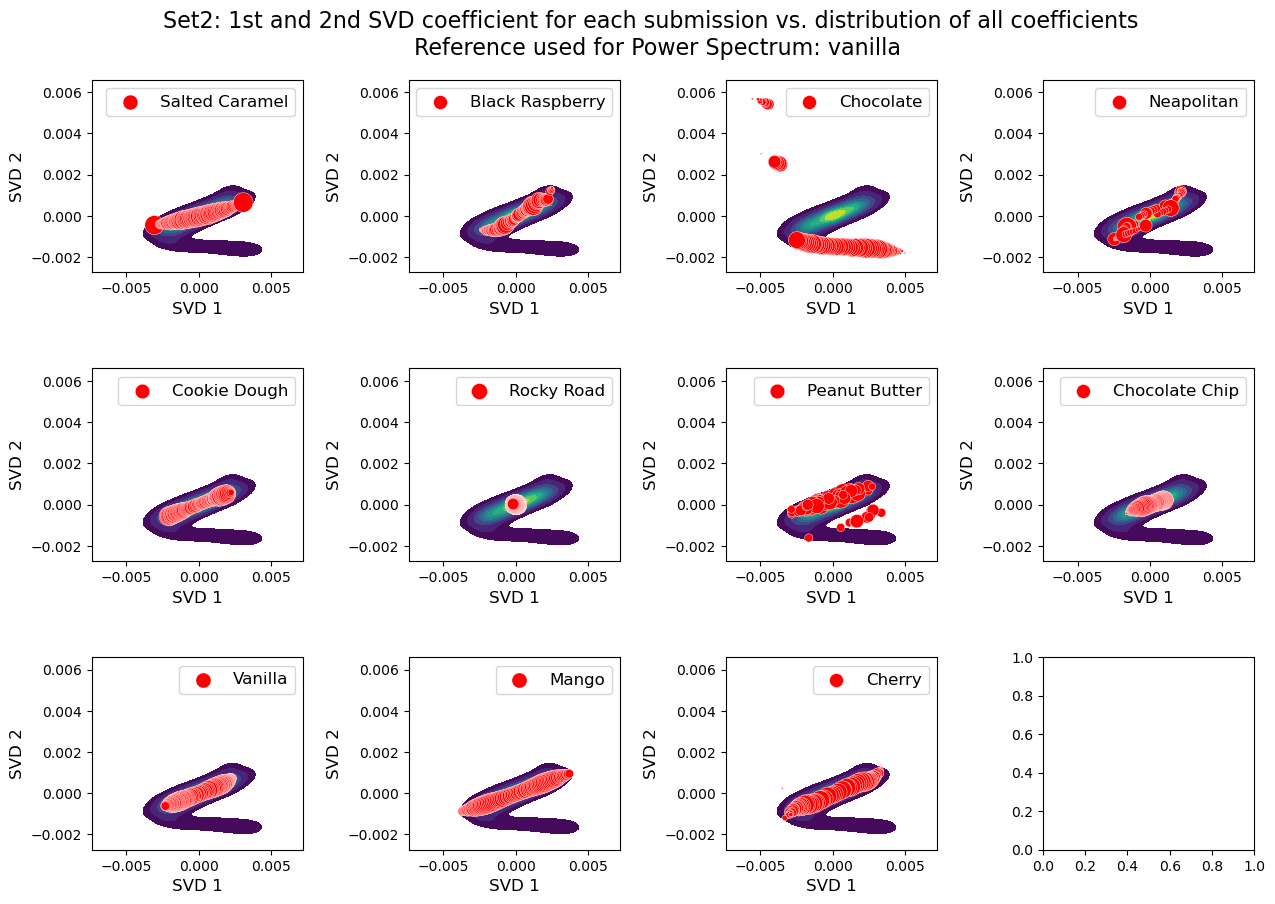

In [8]:
Image(filename="figures/svd_example_all_vs_all_set2.png")

# Analysis for Set 1

In set 1 we only have the submissions vs submissions case

Let's repeat the same process as before

In [ ]:
# Select path to SVD results
results_svd_all_vs_all_set1_path = FileChooser(os.path.expanduser("~"))
results_svd_all_vs_all_set1_path.filter_pattern = "*.pt"
display(results_svd_all_vs_all_set1_path)

In [ ]:
results_svd_all_vs_all_set1 = torch.load(results_svd_all_vs_all_set1_path.value)

In [ ]:
title_fig = "your title"
fig_fname = "your figfname"  # for saving a file (optional)

plot_all_vs_ref_plot1(results_svd_all_vs_ref, title_fig, fig_fname=fig_fname)

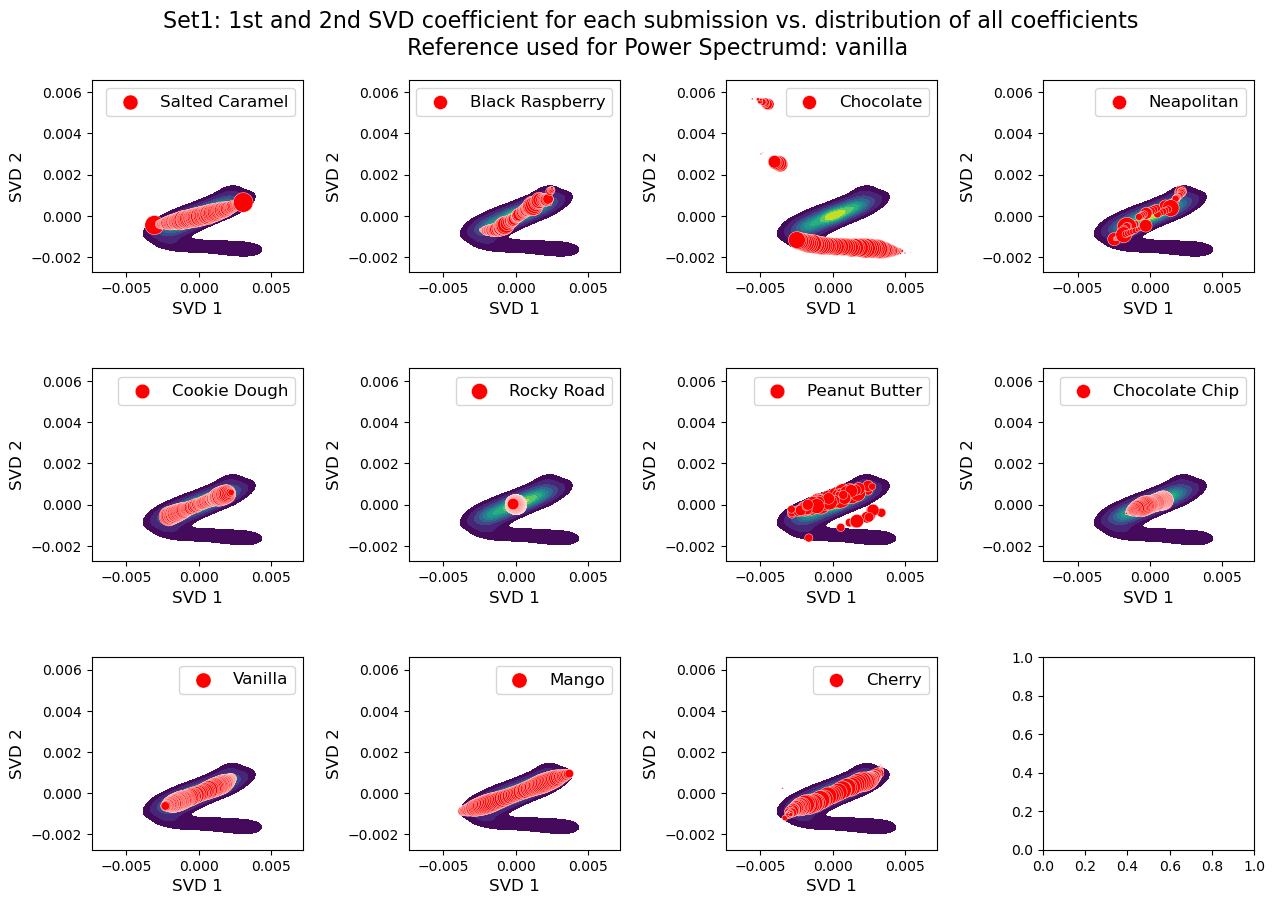

In [9]:
Image(filename="figures/svd_example_all_vs_all_set1.png")